In [3]:
!pip install rasterio
!pip install wandb

     |████████████████████████████████| 19.2 MB 16.7 MB/s            
     |████████████████████████████████| 16.8 MB 22.4 MB/s            
  Using cached affine-2.3.1-py2.py3-none-any.whl (16 kB)
     |████████████████████████████████| 149 kB 24.7 MB/s            
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
     |████████████████████████████████| 96 kB 19.5 MB/s            
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
You should consider upgrading via the '/home/mcgrau/PycharmProjects/SS22_AIML/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.8 MB 3.2 MB/s            
     |████████████████████████████████| 1.0 MB 26.9 MB/s            
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
     |████████████████████████████████| 661 kB 31.3 MB/s            
     |

In [4]:
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip

--2022-04-18 12:24:13--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  16.9MB/s    in 2m 17s  

2022-04-18 12:26:30 (14.4 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [5]:
!unzip *.zip

Archive:  EuroSATallBands.zip
   creating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/
   creating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1619.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1278.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_876.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_404.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_372.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_713.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/PermanentCrop_1456.tif  
  inflating: ds/images/remote_sensing/otherDatasets/sentinel_2/tif/PermanentCrop/P

In [10]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import torchvision.transforms as transforms

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import wandb
import pandas as pd
from PIL import Image

In [18]:
# create models sub-directory inside the Colab Notebooks directory
models_directory = '/home/mcgrau/PycharmProjects/SS22_AIML/models'
test_directory = '/home/mcgrau/PycharmProjects/SS22_AIML/data/testset'

In [19]:
#thats how to load that data i suppose
dataset = ImageFolder(root='ds/images/remote_sensing/otherDatasets/sentinel_2/tif')
print(dataset.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [20]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

In [21]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

In [22]:
def show_rgb(img):
  img = reshape_as_image(img)
  normalized_img = normalize_for_display(img)
  rgb_img = normalized_img[:, :, [3,2,1]]
  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow(rgb_img)
  ax.set_title(f"{label}")
  ax.axis(False)
  plt.tight_layout()
  plt.show()

In [23]:
# change this to your eurosat path
eurosat_dir = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

In [24]:
sample_idx = 111
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]
print(label)

PermanentCrop


In [25]:
with rio.open(sample, "r") as d:
    # read specific bands:
    # B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])
img.shape

(13, 64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


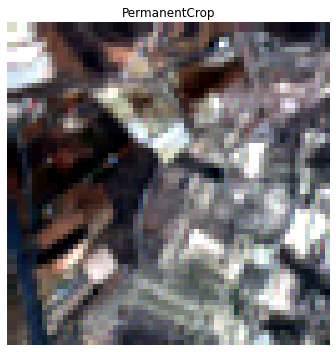

In [26]:
show_rgb(img)

In [27]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [28]:
!nvidia-smi

Mon Apr 18 12:41:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0    20W /  N/A |     13MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [30]:
class SatelliteDataset(Dataset):
    """Create own dataset."""

    def __init__(self, transform=False):
        self.eurosat_dir = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
        self.samples = glob.glob(os.path.join(self.eurosat_dir, "*", "*.tif"))
        self.transform = transform

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input = self.samples[idx]
        label = input.split('/')[-1].split('_')[0]
        label = class_to_idx[label]
        with rio.open(input, "r") as d:
          image = d.read([1,2,3,4,5,6,7,8,9,11,12,13]).astype(int)
          image = reshape_as_image(image)

        if self.transform:
            image = transforms.ToTensor()(image)

        return image, label

In [31]:
trainData = SatelliteDataset(transform = True)

In [32]:
#define Cifar10Net
# implement the CIFAR10Net network architecture
class CIFAR10Net(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(CIFAR10Net, self).__init__()

        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=6, kernel_size=5, stride=1, padding=0)

        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        # define max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify fc layer 1 - in 16 * 13 * 13, out 120
        self.linear1 = nn.Linear(16 * 13 * 13, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity

        # specify fc layer 2 - in 120, out 84
        self.linear2 = nn.Linear(120, 84, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 84, out 10
        self.linear3 = nn.Linear(84, 10) # the linearity W*x+b

        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

    # define network forward pass
    def forward(self, images):

        # high-level feature learning via convolutional layers

        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))

        # define conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))

        # feature flattening

        # reshape image pixels
        x = x.view(-1, 16 * 13 * 13)

        # combination of feature learning via non-linear layers

        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))

        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))

        # return forward pass result
        return x

In [33]:
model = CIFAR10Net()
model = model.to(device)

In [34]:
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

In [35]:
learning_rate = 0.001
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [128]:
num_epochs = 150
mini_batch_size = 3900
train_loader = DataLoader(trainData, batch_size=mini_batch_size, shuffle=True, num_workers=0)

In [129]:
torch.autograd.set_detect_anomaly(False)

# start monitoring
wandb.init()

# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_loader):

        # push mini-batch data to computation device
        images = images.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.float)

        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        labels=labels.to(torch.int64)

        # determine classification loss
        loss = nll_loss(output, labels)

        # run backward pass
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # set filename of actual model
    model_name = 'cifar10_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    if (epoch % 10) == 0 or epoch == (num_epochs - 1):
      torch.save(model.state_dict(), os.path.join(models_directory, model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20220418-19:35:46] epoch: 0 train-loss: 0.2504142629248755
[LOG 20220418-19:36:56] epoch: 1 train-loss: 0.23191272573811667
[LOG 20220418-19:38:07] epoch: 2 train-loss: 0.20365273739610398
[LOG 20220418-19:39:17] epoch: 3 train-loss: 0.18666668023381913
[LOG 20220418-19:40:28] epoch: 4 train-loss: 0.16931628116539546
[LOG 20220418-19:41:38] epoch: 5 train-loss: 0.15703322206224715
[LOG 20220418-19:42:48] epoch: 6 train-loss: 0.1451517002923148
[LOG 20220418-19:43:57] epoch: 7 train-loss: 0.13215515123946325
[LOG 20220418-19:45:05] epoch: 8 train-loss: 0.12953088219676698
[LOG 20220418-19:46:12] epoch: 9 train-loss: 0.1178169112120356
[LOG 20220418-19:47:19] epoch: 10 train-loss: 0.11630594304629735
[LOG 20220418-19:48:26] epoch: 11 train-loss: 0.1046460313456399
[LOG 20220418-19:49:33] epoch: 12 train-loss: 0.10030536672898702
[LOG 20220418-19:50:40] epoch: 13 train-loss: 0.09439431343759809
[LOG 20220418-19:51:46] epoch: 14 train-loss: 0.09301073104143143
[LOG 20220418-19:52:53] 

wandb: Network error (ReadTimeout), entering retry loop.


[LOG 20220418-21:15:18] epoch: 86 train-loss: 0.028232470154762268
[LOG 20220418-21:16:24] epoch: 87 train-loss: 0.028847253748348782
[LOG 20220418-21:17:31] epoch: 88 train-loss: 0.02827648924929755
[LOG 20220418-21:18:38] epoch: 89 train-loss: 0.027098707588655607
[LOG 20220418-21:19:44] epoch: 90 train-loss: 0.025447462552360127
[LOG 20220418-21:20:51] epoch: 91 train-loss: 0.024783788781080927
[LOG 20220418-21:21:57] epoch: 92 train-loss: 0.02465654457254069
[LOG 20220418-21:23:05] epoch: 93 train-loss: 0.02527456171810627
[LOG 20220418-21:24:13] epoch: 94 train-loss: 0.025041170152170316
[LOG 20220418-21:25:20] epoch: 95 train-loss: 0.025117239515696253
[LOG 20220418-21:26:28] epoch: 96 train-loss: 0.02443250428353037
[LOG 20220418-21:27:36] epoch: 97 train-loss: 0.022354860923119953
[LOG 20220418-21:28:44] epoch: 98 train-loss: 0.023004769746746336
[LOG 20220418-21:29:52] epoch: 99 train-loss: 0.11084172342504774
[LOG 20220418-21:31:00] epoch: 100 train-loss: 3.4194601263318742


KeyboardInterrupt: 

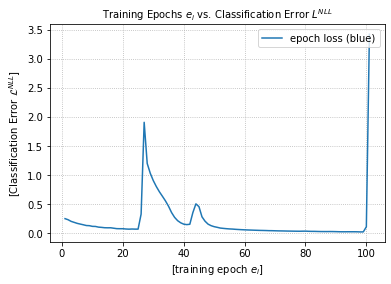

In [130]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

In [45]:
print(test_directory)

/home/mcgrau/PycharmProjects/SS22_AIML/data/testset


In [46]:
testSamples = glob.glob(os.path.join(test_directory, "*.npy"))
len(testSamples)

4232

In [47]:
class testDataset(Dataset):
    def __init__(self, test_directory, transform=False):
        self.files = glob.glob(os.path.join(test_directory, "*.npy"))
        self.transform = transform

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):
        item = self.files[idx]
        image = np.load(item).astype(int)
        number = int(item.split('/')[-1].split('_')[1].split('.')[0])

        if self.transform:
          image = transforms.ToTensor()(image).to(torch.float)

        return image, number

In [80]:
testData = testDataset(test_directory = test_directory, transform = True)

In [91]:
test_loader = DataLoader(testData, shuffle=False)

In [92]:
# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'cifar10_model_epoch_200.pth')

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = CIFAR10Net()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

<All keys matched successfully>

In [93]:
# set model in evaluation mode
best_model.eval()

CIFAR10Net(
  (conv1): Conv2d(12, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2704, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [114]:
predictions = []
numbers = []

for i, (images, nums) in enumerate(test_loader):
    # run forward pass through the network
    pred = torch.argmax(best_model(images), dim=1)
    predictions.append(pred.int().item())
    numbers.append(nums.int().item())

In [115]:
print(len(predictions))

4232


In [120]:
print(numbers)

[3092, 292, 3463, 2840, 95, 3872, 3139, 1679, 3268, 786, 2560, 2001, 1500, 4146, 4169, 1344, 1237, 2490, 873, 4213, 3316, 1172, 3148, 1995, 4112, 2762, 1892, 2154, 833, 1777, 1973, 55, 3136, 1522, 856, 1813, 2936, 561, 864, 3894, 3416, 2582, 1192, 3299, 3747, 4173, 1868, 720, 3364, 663, 3798, 2158, 2491, 907, 3943, 4070, 3167, 4085, 2908, 4036, 3585, 2300, 78, 3744, 2666, 3392, 3771, 1636, 489, 1998, 4189, 3902, 1888, 2554, 2339, 2004, 3290, 4051, 1408, 685, 1936, 1698, 1371, 2643, 52, 1937, 3598, 1849, 465, 749, 3501, 1361, 3564, 2849, 3173, 38, 575, 653, 2382, 2359, 3714, 3330, 3726, 2782, 2537, 3422, 1445, 2091, 1451, 2687, 2893, 3487, 1248, 2090, 2406, 949, 682, 1231, 3937, 2410, 459, 352, 3078, 3724, 3871, 401, 2544, 658, 1031, 3269, 1337, 2189, 228, 3313, 1533, 958, 1128, 2044, 1358, 2773, 4082, 4017, 643, 1116, 3368, 380, 2751, 2363, 2641, 480, 2063, 426, 2183, 825, 987, 2381, 2467, 3452, 3745, 1398, 2981, 1673, 265, 1917, 2618, 394, 2128, 4099, 2344, 2610, 1285, 3117, 1771, 413

In [121]:
predClasses = np.vectorize(idx_to_class.get)(predictions)

d = {'test_id': numbers, 'label': predClasses}
predData = pd.DataFrame(data = d)
predData = predData.sort_values(by=['test_id'])
print(predData.head(10))

      test_id                 label
2829        0  HerbaceousVegetation
2326        1               Highway
3410        2  HerbaceousVegetation
2701        3           Residential
3763        4               Highway
3752        5         PermanentCrop
3271        6  HerbaceousVegetation
1273        7  HerbaceousVegetation
1029        8  HerbaceousVegetation
3926        9         PermanentCrop


In [122]:
print(len(predData))

4232


In [123]:
predData.to_csv(os.path.join(models_directory,'submission.csv'), index = False)

In [57]:
idx_to_class

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

In [58]:
print(predictions[0])

tensor([7, 9, 9,  ..., 4, 9, 2])


In [59]:
np.unique(preds)

NameError: name 'preds' is not defined